In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/SejongMusic


In [3]:
from sejong_music.yeominrak_processing import AlignedScore


class MaskedDataset:
    def __init__(self, aligned_score: AlignedScore):
        self.aligned_score = aligned_score

    def __len__(self):
        return len(self.masked_score)

    def __getitem__(self, idx):
        return self.aligned_score[idx]
      
dataset = MaskedDataset(aligned_score=AlignedScore())

In [23]:
aligned_score = AlignedScore()

In [4]:
len(aligned_score.measure_features[1])

160

In [4]:
import numpy as np
class BeatPosConverter:
  def __init__(self) -> None:
    self.era_group = [(0, 1), (2, 3, 4, 5), (6, 7)]
    self.era2group = {era:group for group, eras in enumerate(self.era_group) for era in eras}
    self.anchor_points =  [
      {0.0:0.0, 2.0: 2.0, 3.0:3.0, 5.0:6.0, 6.0:8.0, 7.0:9.0, 8.0:10.0},
      {0.0:0.0, 1.0:1.0, 2.0:2.0, 3.0:3.0, 6.0:5.0, 7.0:6.0, 8.0:7.0, 9.0:8.0, 10.0:10.0},
    ]
    self.measure_len = [8, 8, 10, 10, 10, 10, 10, 10]
  
  def __call__(self, beat_pos:float, org_era_idx:int, target_era_idx:int):
    org_group, target_group = self.era2group[org_era_idx], self.era2group[target_era_idx]
    if org_group == target_group:
      return beat_pos
    assert abs(org_group - target_group) == 1, f"Only one group difference is allowed. {org_era_idx} -> {target_era_idx}"
    if beat_pos >= self.measure_len[org_era_idx]:
      num_measures = int(beat_pos // self.measure_len[org_era_idx])
      beat_pos -= num_measures * self.measure_len[org_era_idx]
    else:
      num_measures = 0


    lower_group = min(org_group, target_group)
    
    anchor_points = self.anchor_points[lower_group]
    forward = np.array(list(anchor_points.keys()))
    backward = np.array(list(anchor_points.values()))
    if org_group > target_group:
      backward, forward = forward, backward
    conv_beat_pos = np.interp(beat_pos, forward, backward)
    return conv_beat_pos + num_measures * self.measure_len[target_era_idx]
    
                          
    
b_pos_conv = BeatPosConverter()
b_pos_conv(9.0, 5, 7)
    
assert b_pos_conv(0.0, 0, 1) == 0.0
assert b_pos_conv(0.0, 1, 0) == 0.0
assert b_pos_conv(0.0, 0, 2) == 0.0
assert b_pos_conv(0.0, 2, 0) == 0.0
assert b_pos_conv(4.0, 1, 5) == 4.5, b_pos_conv(4.0, 1, 5)
assert abs(b_pos_conv(4.0, 5, 1) - 3.66666) < 0.0001
assert abs(b_pos_conv(5.0, 5, 7) - 4.33333) < 0.0001
assert b_pos_conv(5.0, 7, 5) == 6.0
assert abs(b_pos_conv(4.33333, 7, 5) - 5.0) < 0.0001

In [5]:
b_pos_conv(4.5, 5, 7)

4.0

In [94]:
from tqdm.auto import tqdm
from sejong_music.tokenizer import SingleVocabTokenizer
import numpy as np

class EraAlignPairSet:
  pos_conv = BeatPosConverter()
  
  def __init__(self, aligned_score:AlignedScore, slice_len:int=4, hop_len:int=1):
    if isinstance(aligned_score, AlignedScore):
      self.aligned_score = aligned_score
    else:
      self.aligned_score = AlignedScore()
    self.slice_len = slice_len
    self.hop_len = hop_len
    self.data_pairs = self.collect_dataset()
    self.tokenizer = SingleVocabTokenizer(unique_tokens=self.get_unique_words())
      
  def collect_dataset(self):
    total_outputs = []
    for front_idx in range(1, len(self.aligned_score.measure_features)-1):
      back_idx = front_idx + 1
      for start_measure in range(0, len(self.aligned_score.measure_features[front_idx])-self.slice_len, self.hop_len):
        end_measure = start_measure + self.slice_len
        pairs = self.get_align_pair_by_part_and_measure(front_idx, back_idx, start_measure, end_measure)
        notes = [self._convert_note_feature_to_str_list(x[0]) for x in pairs]
        labels = [x[1] for x in pairs]
        total_outputs.append([*zip(notes, labels)])
    total_outputs = [x for x in total_outputs if len(x)>0]
    return total_outputs
  
  def get_unique_words(self):
    unique_words = set()
    for sequence in self.data_pairs:
      notes = [x[0] for x in sequence]
      for note in notes:
        unique_words.update(note)
    return unique_words

  def get_align_pair_by_part_and_measure(self, front_idx:int, back_idx:int, start_measure:int, end_measure:int):
    assert front_idx < back_idx, f"front_idx should be smaller than back_idx. {front_idx} >= {back_idx}"
    assert start_measure < end_measure, f"start_measure should be smaller than end_measure. {start_measure} >= {end_measure}"
    # if len(self.aligned_score.measure_features[front_idx]) < start_measure: return []
    # if len(self.aligned_score.measure_features[back_idx]) < start_measure: return []
    front_part = self.aligned_score.measure_features[front_idx][start_measure:end_measure]
    front_part = [note for measure in front_part for note in measure]
    back_part = self.aligned_score.measure_features[back_idx][start_measure:end_measure]
    back_part = [note for measure in back_part for note in measure]

    front_part_duration = sum([x[2] for x in front_part])
    back_part_duration = sum([x[2] for x in back_part])
    # print(f"Front duration: {front_part_duration}, Back duration: {back_part_duration}")
    if front_part_duration != self.pos_conv.measure_len[front_idx] * (end_measure - start_measure): return []
    if back_part_duration != self.pos_conv.measure_len[back_idx] * (end_measure - start_measure): return []

    f_accum_position = np.cumsum([0] + [note[2] for note in front_part])
    b_accum_position = np.cumsum([0] + [note[2] for note in back_part])
    pairs = []
    b_note_id = 0
    for f_note_id, f_note in enumerate(front_part):
      f_pos = self.pos_conv(f_accum_position[f_note_id], front_idx, back_idx)
      b_pos = b_accum_position[b_note_id]
      while f_pos > b_pos and b_note_id < len(back_part)-1:
        b_note_id += 1
        b_pos = b_accum_position[b_note_id]
      b_note = back_part[b_note_id]
      is_transferred = f_note[1] == b_note[1]
      pairs.append( (f_note, is_transferred))
    return pairs
  
  def __len__(self):
    return len(self.data_pairs)
  
  @staticmethod
  def convert_duration(dur:float):
    if dur < 0.5: return 'veryshort'
    elif dur < 1.0: return 'short'
    elif dur < 2.0: return 'long'
    else: return 'verylong'
  
  def _convert_note_feature_to_str_list(self, note):
    return [f"era{note[0]}", f"pitch{int(note[1])}", self.convert_duration(note[2]), note[4]]
  
  def __getitem__(self, idx):
    sequence = self.data_pairs[idx]
    notes = self.tokenizer([x[0] for x in sequence])
    labels = [x[1] for x in sequence]
    
    return torch.LongTensor(notes), torch.tensor(labels, dtype=torch.float)



dataset = EraAlignPairSet(aligned_score=aligned_score)
# dataset.get_align_pair_by_part_and_measure(4,5, 40, 45)
dataset[0]

(tensor([[ 3, 13, 30, 28],
         [ 3, 20, 29, 28],
         [ 3, 20, 29, 28],
         [ 3, 13, 30, 28],
         [ 3, 20, 29, 28],
         [ 3, 20,  9, 28],
         [ 3, 21,  9, 31],
         [ 3, 20,  9, 31],
         [ 3, 13, 30, 28],
         [ 3, 18, 29, 28],
         [ 3, 17, 29, 10],
         [ 3, 13, 30, 28],
         [ 3, 18,  9, 28],
         [ 3, 20,  9, 31],
         [ 3, 18,  9, 31],
         [ 3, 13, 30, 28],
         [ 3, 17, 29, 28],
         [ 3, 16,  9, 31],
         [ 3, 17, 29, 10],
         [ 3, 13, 30, 28],
         [ 3, 18,  9, 28],
         [ 3, 17,  9, 31],
         [ 3, 18,  9, 31]]),
 tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
         1., 0., 0., 1., 0.]))

In [144]:
import torch.nn as nn
import torch
from torch.nn.utils.rnn import PackedSequence, pack_sequence
from sejong_music.module import SumEmbeddingSingleVocab

class AlignPredictor(nn.Module):
  def __init__(self, vocab_size, hidden_size=32, dropout=0.2):
    super(AlignPredictor, self).__init__()
    self.emb = SumEmbeddingSingleVocab(vocab_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    if isinstance(x, PackedSequence):
      emb = PackedSequence(self.dropout(self.emb(x.data)), x[1], x[2], x[3])
      hidden, _ = self.gru(emb)
      return PackedSequence(self.fc(self.dropout(hidden.data)).sigmoid(), x[1], x[2], x[3])
    emb = self.dropout(self.emb(x))
    hidden, _ = self.gru(emb)
    return self.dropout(self.fc(hidden)).sigmoid()

def pack_collate(raw_batch):
  seq, label = zip(*raw_batch)
  return pack_sequence(seq, enforce_sorted=False), pack_sequence(label, enforce_sorted=False).float()

# random split dataset into subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

dataset = EraAlignPairSet(aligned_score=aligned_score, hop_len=4)
# random split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pack_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pack_collate)

align_predictor = AlignPredictor(vocab_size=len(dataset.tokenizer.vocab))


batch = next(iter(train_loader))

In [153]:


model = AlignPredictor(vocab_size=len(dataset.tokenizer.vocab), hidden_size=64, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

loss_record = []
acc_record = []
n_epoch = 200
model = model.cuda()

for _ in tqdm(range(n_epoch)):
  model.train()
  for batch in train_loader:
    optimizer.zero_grad()
    seq, label = batch
    pred = model(seq.cuda())
    loss = nn.BCELoss()(pred.data.squeeze(), label.data.cuda())
    loss.backward()
    optimizer.step()
    loss_record.append(loss.item())
  
  with torch.inference_mode():
    total_num_correct = 0
    total_samples = 0
    model.eval()
    for batch in test_loader:
      seq, label = batch
      pred = model(seq.cuda())
      pred = pred.data.squeeze()
      num_correct = ((pred > 0.5) == label.data.cuda()).sum()
      total_num_correct += num_correct.item()
      total_samples += label.data.numel()
    acc_record.append(total_num_correct / total_samples)

print(max(acc_record))

100%|██████████| 200/200 [00:09<00:00, 22.20it/s]

0.7583333333333333


In [157]:
torch.save(model.state_dict(), 'models/align_predictor.pt')

In [162]:
dataset.tokenizer.save_to_json('models/align_predictor_vocab.json')

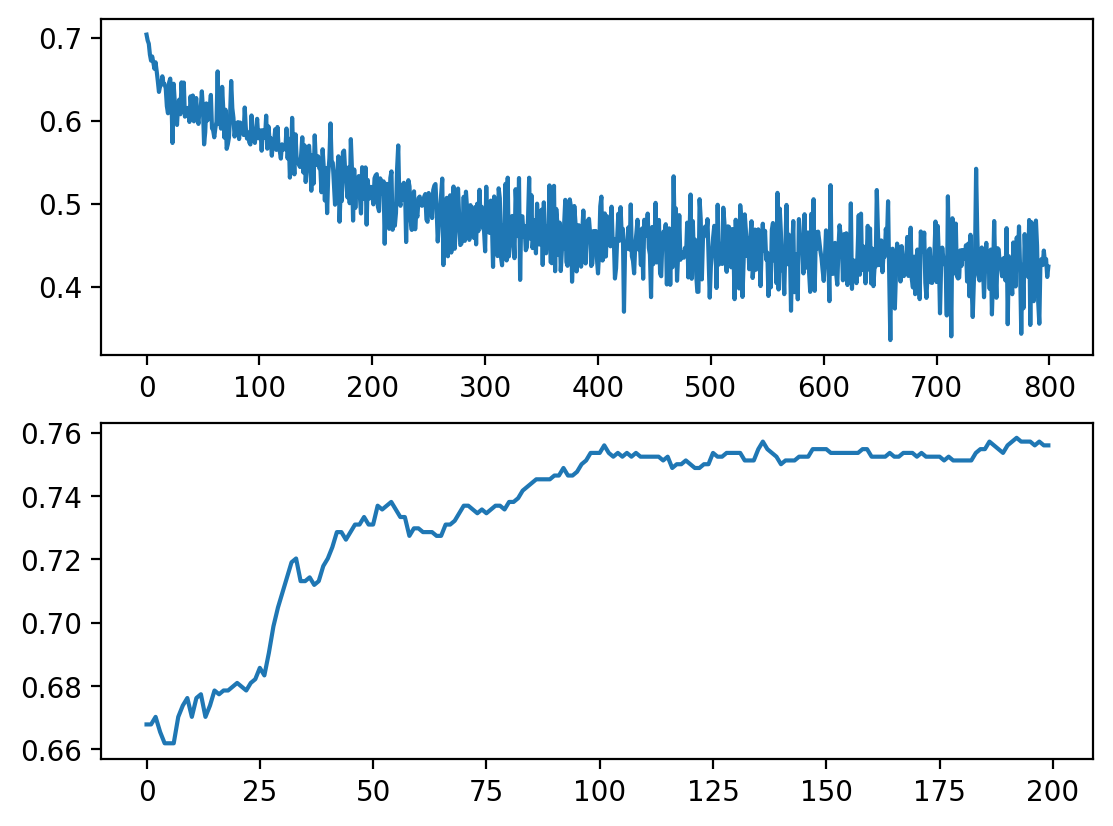

In [154]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(loss_record)
plt.subplot(2,1,2)
plt.plot(acc_record)

In [18]:
def align_notes(front_part, back_part, front_idx, back_idx):
  f_accum_position = np.cumsum([0] + [note[2] for note in front_part])
  b_accum_position = np.cumsum([0] + [note[2] for note in back_part])
  f_note_id = 0
  b_note_id = 0
  pairs = []
  for f_note_id, f_note in enumerate(front_part):
    f_pos = b_pos_conv(f_accum_position[f_note_id], front_idx, back_idx)
    b_pos = b_accum_position[b_note_id]
    # print(f" f_pos: {f_pos}, b_pos: {b_pos}")
    while f_pos > b_pos and b_note_id < len(back_part)-1:
      b_note_id += 1
      b_pos = b_accum_position[b_note_id]
    b_note = back_part[b_note_id]
    is_transferred = f_note[1] == b_note[1]
    pairs.append( (f_note, is_transferred))
  return pairs


  
pairs

[([3, 51.0, 1.0, 0.0, 'strong', 1], True),
 ([3, 39.0, 0.0, 1.0, 'weak', 1], True),
 ([3, 51.0, 2.0, 1.0, 'weak', 1], False),
 ([3, 51.0, 3.0, 3.0, 'middle', 1], True),
 ([3, 39.0, 0.0, 6.0, 'strong', 1], False),
 ([3, 51.0, 2.0, 6.0, 'strong', 1], True),
 ([3, 48.0, 1.0, 8.0, 'middle', 1], True),
 ([3, 53.0, 1.0, 9.0, 'weak', 1], True),
 ([3, 39.0, 0.0, 0.0, 'strong', 2], False),
 ([3, 51.0, 2.0, 0.0, 'strong', 2], True),
 ([3, 48.0, 1.0, 2.0, 'weak', 2], True),
 ([3, 51.0, 3.0, 3.0, 'middle', 2], True),
 ([3, 39.0, 0.0, 6.0, 'strong', 2], False),
 ([3, 56.0, 2.0, 6.0, 'strong', 2], True),
 ([3, 53.0, 1.0, 8.0, 'middle', 2], False),
 ([3, 51.0, 1.0, 9.0, 'weak', 2], True)]

In [ ]:

'''
while f_note_id < len(front_part) and b_note_id < len(back_part):
    f_pos = b_pos_conv(f_accum_position[f_note_id], front_idx, back_idx)
    b_pos = b_accum_position[b_note_id]
    # print(f" f_pos: {f_pos}, b_pos: {b_pos}")
    if f_pos > b_pos:
      b_note_id += 1
      continue
    elif f_pos < b_pos:
      f_note_id += 1
      continue
    f_note = front_part[f_note_id]
    b_note = back_part[b_note_id]
    if f_note[1] == b_note[1]:
        print(f_note, b_note)
    f_note_id += 1
    b_note_id += 1
'''

In [17]:

from music21 import converter
from pathlib import Path
from typing import List, Union
import pickle
from sejong_music.yeominrak_processing import Part


class T5Dataset:
  def __init__(self, xml_path) -> None:
    self.score = converter.parse(xml_path)
    # self.parts = [Part(part, i+start_part_idx) for i, part in enumerate(self.score.parts)]
    if Path(xml_path).with_suffix('.pkl').exists():
        self.parts = pickle.load(open(Path(xml_path).with_suffix('.pkl'), 'rb'))
    else:
        self.parts = [Part(part, i) for i, part in enumerate(self.score.parts)]
        pickle.dump(self.parts, open(Path(xml_path).with_suffix('.pkl'), 'wb'))
        
  def __len__(self):
    return len(self.parts)


dataset = T5Dataset('music_score/yeominlak.musicxml')

In [30]:


class AlignedMeasure:
  measure_length = [4, 8, 10, 10, 10, 10, 10, 10]
  
  def __init__(self, measures: List, measure_idx: int) -> None:
    assert len(measures) == 8, f"measures should be 8 but got {len(measures)}"
    self.measures = measures
    self.number = measure_idx
    self.is_valid = self.check_measure_dur(measures)
    
  
  @classmethod
  def check_measure_dur(cls, measures):
    measure_len_by_era = [ round(sum([note.duration for note in era_measure]), 4) for era_measure in measures]
    return measure_len_by_era == cls.measure_length
  
  def __repr__(self) -> str:
    return f"AlignedMeasure({self.number}), valid: {self.is_valid}"


class AlignmentResult:
  def __init__(self, parts: List[Part]):
    self.parts = parts
    self.measures = [AlignedMeasure([part.measures[i] for part in parts], i) for i in range(len(parts[0].measures))]
  

  
parts = dataset.parts

align_result = AlignmentResult(parts)
align_result.measures

[AlignedMeasure(0), valid: True,
 AlignedMeasure(1), valid: True,
 AlignedMeasure(2), valid: True,
 AlignedMeasure(3), valid: True,
 AlignedMeasure(4), valid: True,
 AlignedMeasure(5), valid: True,
 AlignedMeasure(6), valid: True,
 AlignedMeasure(7), valid: True,
 AlignedMeasure(8), valid: True,
 AlignedMeasure(9), valid: True,
 AlignedMeasure(10), valid: True,
 AlignedMeasure(11), valid: True,
 AlignedMeasure(12), valid: True,
 AlignedMeasure(13), valid: True,
 AlignedMeasure(14), valid: False,
 AlignedMeasure(15), valid: False,
 AlignedMeasure(16), valid: False,
 AlignedMeasure(17), valid: False,
 AlignedMeasure(18), valid: False,
 AlignedMeasure(19), valid: False,
 AlignedMeasure(20), valid: False,
 AlignedMeasure(21), valid: False,
 AlignedMeasure(22), valid: False,
 AlignedMeasure(23), valid: True,
 AlignedMeasure(24), valid: True,
 AlignedMeasure(25), valid: True,
 AlignedMeasure(26), valid: True,
 AlignedMeasure(27), valid: True,
 AlignedMeasure(28), valid: True,
 AlignedMeasure

In [16]:
dataset.parts[2].measures

[[Gnote: 51.0, 3.0, 0.0, strong,
  Gnote: 51.0, 3.0, 3.0, middle,
  Gnote: 51.0, 2.0, 6.0, strong,
  Gnote: 48.0, 1.0, 8.0, middle,
  Gnote: 53.0, 1.0, 9.0, weak],
 [Gnote: 51.0, 2.0, 0.0, strong,
  Gnote: 48.0, 1.0, 2.0, weak,
  Gnote: 51.0, 3.0, 3.0, middle,
  Gnote: 56.0, 2.0, 6.0, strong,
  Gnote: 53.0, 1.0, 8.0, middle,
  Gnote: 51.0, 1.0, 9.0, weak],
 [Gnote: 48.0, 2.0, 0.0, strong,
  Gnote: 48.0, 1.0, 2.0, weak,
  Gnote: 46.0, 3.0, 3.0, middle,
  Gnote: 48.0, 1.0, 6.0, strong,
  Gnote: 53.0, 1.0, 7.0, weak,
  Gnote: 51.0, 1.0, 8.0, middle,
  Gnote: 48.0, 1.0, 9.0, weak],
 [Gnote: 46.0, 2.0, 0.0, strong,
  Gnote: 44.0, 1.0, 2.0, weak,
  Gnote: 46.0, 3.0, 3.0, middle,
  Gnote: 51.0, 1.0, 6.0, strong,
  Gnote: 48.0, 1.0, 7.0, weak,
  Gnote: 46.0, 1.0, 8.0, middle,
  Gnote: 44.0, 1.0, 9.0, weak],
 [Gnote: 53.0, 3.0, 0.0, strong,
  Gnote: 53.0, 3.0, 3.0, middle,
  Gnote: 51.0, 2.0, 6.0, strong,
  Gnote: 53.0, 1.0, 8.0, middle,
  Gnote: 56.0, 1.0, 9.0, weak],
 [Gnote: 53.0, 3.0, 0.0, 

In [11]:
front_part, back_part

NameError: name 'front_part' is not defined

In [5]:
dataset[0]

(tensor([[ 6,  1,  1,  1,  1,  1],
         [ 6, 10,  6,  3,  3,  3],
         [ 6, 13,  6,  4,  5,  3],
         [ 6,  6,  4,  5,  5,  3],
         [ 6, 13, 11,  5,  5,  3],
         [ 6, 13,  8, 11,  4,  3],
         [ 6, 10,  6, 15,  5,  3],
         [ 6, 13,  6, 17,  5,  3],
         [ 6,  6,  4, 19,  3,  3],
         [ 6, 13,  8, 19,  3,  3],
         [ 6, 13,  8, 22,  5,  3],
         [ 6, 16,  8, 25,  4,  3],
         [ 6, 14,  8, 29,  5,  3],
         [ 6, 13,  8, 32,  5,  3],
         [ 6, 10,  6,  3,  3,  4],
         [ 6, 13,  6,  4,  5,  4],
         [ 6,  6,  4,  5,  5,  4],
         [ 6, 13,  8,  5,  5,  4],
         [ 6, 13,  8,  7,  5,  4],
         [ 6, 11,  6, 11,  4,  4],
         [ 6, 13,  6, 13,  5,  4],
         [ 6, 10,  8, 15,  5,  4],
         [ 6, 14,  6, 19,  3,  4],
         [ 6, 16,  6, 20,  5,  4],
         [ 6,  6,  4, 22,  5,  4],
         [ 6, 16,  8, 22,  5,  4],
         [ 6, 16,  8, 25,  4,  4],
         [ 6, 14,  8, 29,  5,  4],
         [ 6, 13,  8